In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches

import shapefile as shp

import pydotplus
from ipywidgets import *
from IPython.display import display
from IPython.display import Image


from tqdm import tqdm_notebook

%config InlineBackend.figure_format = 'retina'


In [50]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the x / y coordinate information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [20]:
path = './datasets/LA_2017_Full_Clipped_Boundaries_in_Great_Britain/Local_Authority_Districts_December_2017_Full_Clipped_Boundaries_in_Great_Britain.shp'
sf = shp.Reader(path)

In [21]:
df = read_shapefile(sf)
df.head(2)

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,coords
0,1,E06000001,Hartlepool,,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523,"[(447213.8995000003, 537036.1042999998), (4472..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561,"[(448958.9007000001, 521835.6952999998), (4490..."


In [22]:
data = pd.read_csv('./datasets/life_expectancy_at_birth_LA.csv')
data = data[['Area Name', 'Male Life expectancy at birth ', 'Female Life expectancy at birth ']]
data['Average_life_expectancy'] = (data['Male Life expectancy at birth '] + data['Female Life expectancy at birth '])/2
data.head(2)

,Area Name,Male Life expectancy at birth,Female Life expectancy at birth,Average_life_expectancy
0,England (non-resident deaths excluded),79.2,83.0,81.1
1,Barking and Dagenham,77.6,82.0,79.8


In [23]:
combined = pd.merge(df, data, left_on = 'lad17nm', right_on='Area Name')

In [53]:
class mapper(): 
    
    def __init__(self, dataframe, data_column=None, default_color = 'r'):
        """
        Initializes the mapper object. 
        
        Parameters
        ----------
        dataframe: pandas dataframe containing a column names 'coords' with x, y coordinates.
        data_column: optional, specify which column in the dataframe is used for determining the alpha (intensity) scale.
        default_color: default color in which the final map will be rendered. 
        
        """
        self.df = dataframe
        self.data_column = data_column
        self.default_color = default_color

    def plot_shape(self, id, text=False, color='r', alpha=1):
        """ plots a single shape from the dataframe"""

        shape = self.df.iloc[id]
            
        x_lon = np.array([x for x, y in shape.coords])
        y_lat = np.array([y for x, y in shape.coords])

        x_lon = np.reshape(x_lon, (-1, 1))
        y_lat = np.reshape(y_lat, (-1, 1))
        
        plt.fill(x_lon,y_lat, color, alpha=alpha)
        
        if text: 

            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)

            plt.text(x0, y0, shape['Area Name'], fontsize=12)
    
    
    def calculate_range(self): 
        """determines the range and quartiles of the data"""
        data = self.df[self.data_column]
        self.data_range = data.max() - data.min()
        self.mid_point = np.median(data)
        self.first_quartile = self.mid_point-self.data_range/4
        self.third_quartile = data.max() - self.data_range/4
            
    def color_intensity(self, x): 
        """ returns a range of alpha values mapped to the range of the data"""

        if x == np.nan: 
            return .01
        elif x > self.third_quartile:
            return .8
        elif x > self.mid_point: 
            return .6
        elif x > self.first_quartile:
            return .4
        return .1
        
    def print_map(self, title=None, threshold=None, figsize=(8,10), savefig=False): 
        """ 
        Creates the map figure. 
        
        Parameters
        ---------
        title: optional, provide a title for the figure
        threshold: optional, if values in the data_column are above the threshold print the name of the geographic entity
        figsize: default is set to (8,10)
        savefig: bool, default False. If True, saves a png image of the map to the local directory
        """
        self.plt_title = title
        self.threshold = threshold
        self.savefig = savefig
        fig, ax = plt.subplots(figsize=(figsize))
        
        self.calculate_range()
        
        for i in tqdm_notebook(range(self.df.shape[0])):
            alpha = self.color_intensity(self.df.iloc[i][self.data_column])
            if self.df[self.data_column][i] > self.threshold:
                self.plot_shape(i, text=True, alpha=alpha, color=self.default_color)       
            else: 
                self.plot_shape(i, alpha=alpha, color=self.default_color)

        plt.axis('off')
        plt.title(title, fontweight='bold', fontsize=16)


        #setting a custom legend
        no_data = mpatches.Patch(color=self.default_color, alpha = .01, label='no data')
        bottom = mpatches.Patch(color=self.default_color, alpha = .1, label='0-25%')
        lower = mpatches.Patch(color=self.default_color, alpha = .4, label='25-50%')
        middle = mpatches.Patch(color=self.default_color, alpha = .6,label='50-75%')
        upper = mpatches.Patch(color=self.default_color, alpha = .6,label='75-100%')
        
        plt.legend(handles=[no_data, bottom, lower, middle, upper], loc=[0.9,0.7], 
                  title='Data distribution', title_fontsize=14)
        legend_marks = mpatches.Patch()

        if self.savefig == True: 
            plt.savefig('map_figure.png', dpi=200, bbox_inches='tight')

        plt.show()

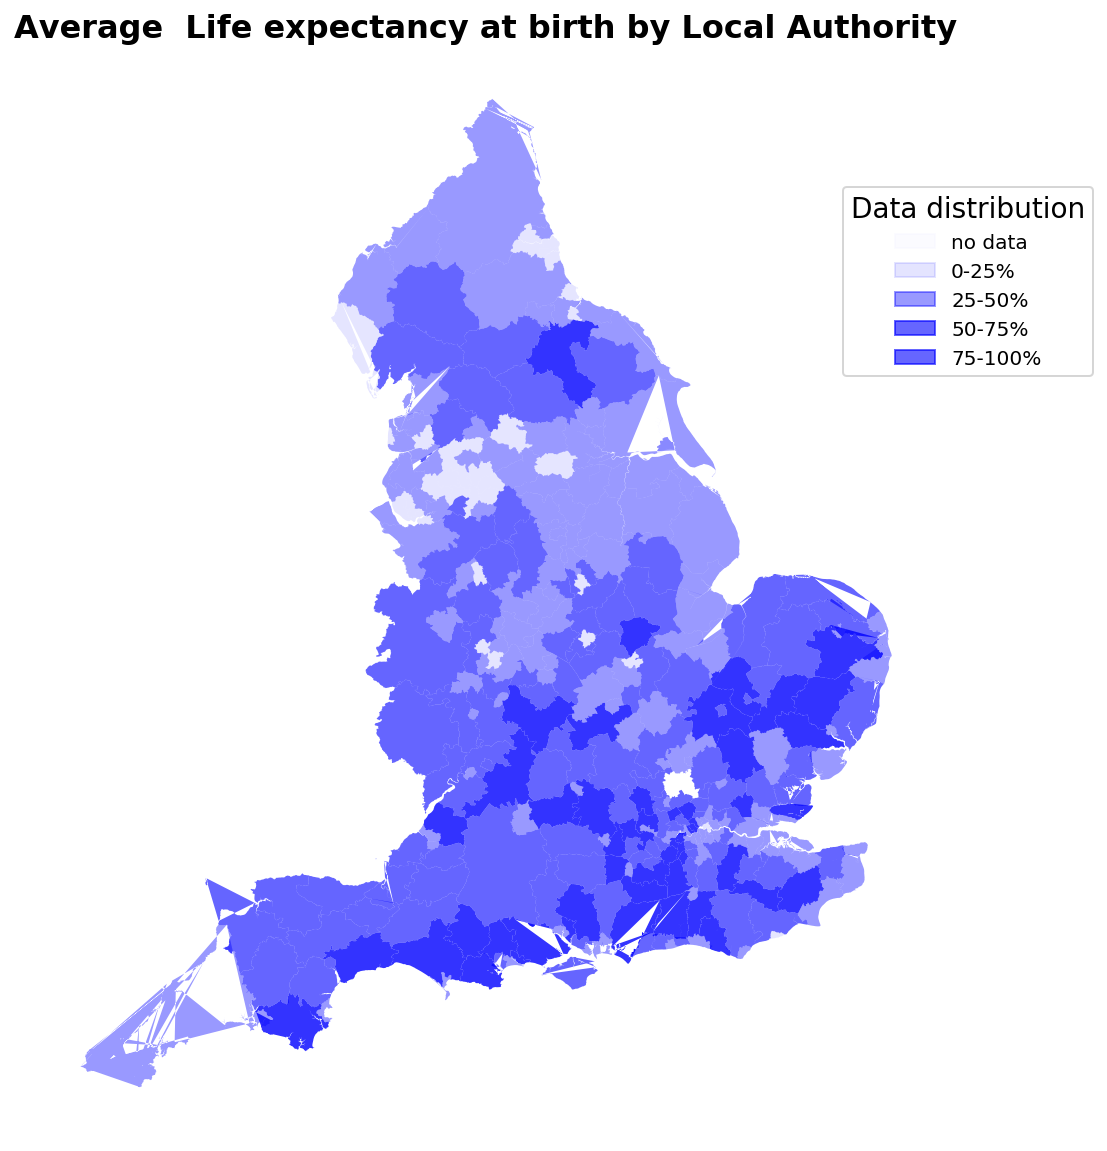

In [54]:
data_column = 'Average_life_expectancy'
title = 'Average  Life expectancy at birth by Local Authority'
LA_map = mapper(combined, data_column=data_column, default_color='b')
LA_map.print_map(threshold=86, title=title, savefig=True)